Nesta seção, vamos entender como **comparar modelos** e como **ajustar os hiper-parâmetros** que definem um modelo.

In [22]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn for plotting defaults
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings("ignore")

#### Validando modelos

In [23]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [27]:
y_pred = knn.predict(X)

In [28]:
print("{0} / {1} correct".format(np.sum(y == y_pred), len(y)))

1797 / 1797 correct


Se você obtiver 100% de acurácia **desconfie**.

In [29]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.shape, X_test.shape

((1347, 64), (450, 64))

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("{0} / {1} correct".format(np.sum(y_test == y_pred), len(y_test)))

442 / 450 correct


In [31]:
# Estamos, na verdade, medindo acurácia do modelo
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.98222222222222222

In [32]:
# Que também pode ser obtido via parâmetro score
knn.score(X_test, y_test)

0.98222222222222222

In [33]:
for n_neighbors in [1, 5, 10, 20, 30]:
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(X_train, y_train)
    print(n_neighbors, knn.score(X_test, y_test))

1 0.982222222222
5 0.984444444444
10 0.971111111111
20 0.957777777778
30 0.948888888889


#### Validação Cruzada

![kfold](../images/kfold.png)

In [36]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5, random_state=0)
X1.shape, X2.shape

((898, 64), (899, 64))

In [37]:
print(KNeighborsClassifier(1).fit(X2, y2).score(X1, y1))
print(KNeighborsClassifier(1).fit(X1, y1).score(X2, y2))

0.983296213808
0.982202447164


In [39]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=2)
cv.mean()

0.96048785080069765

In [42]:
cv = cross_val_score(KNeighborsClassifier(1), X, y, cv=10)
print(cv)

[ 0.93513514  0.99453552  0.97237569  0.98888889  0.96089385  0.98882682
  0.99441341  0.98876404  0.97175141  0.96590909]


In [43]:
cv.mean()

0.97614938602520218

### Selecionando modelo

Em geral, quando temos um modelo que não está atuando com boa performance, 3 ideias surgem:
1. Utilizar um algorítmo mais elaborado
2. Adquirir mais dados
3. Adicionar mais atributos para treinar meu modelo

#### Contraponto Bias

In [46]:
# Criando um conjunto não linear
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

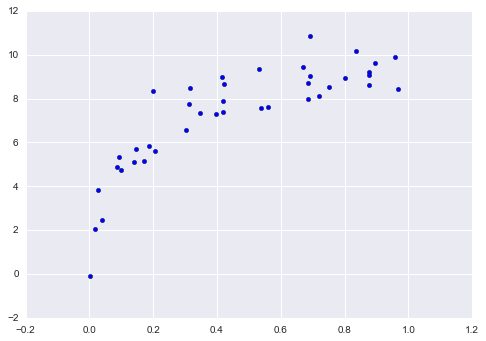

In [47]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);


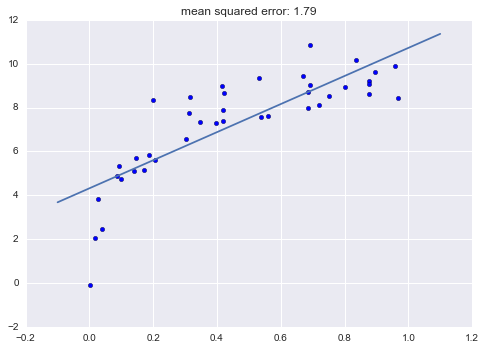

In [48]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

Claramente, a escolha por Regressão Linear para resolver este problema não linear não foi boa.

Neste caso, diz-se que o modelo está **biased** ou **under-fitting**. Ou seja, o modelo **não está generalizando**

In [49]:
# Vamos tentar usar um modelo mais adequado.
# No caso de uma regressão polinomial, podemos ajustar graus de liberdade
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

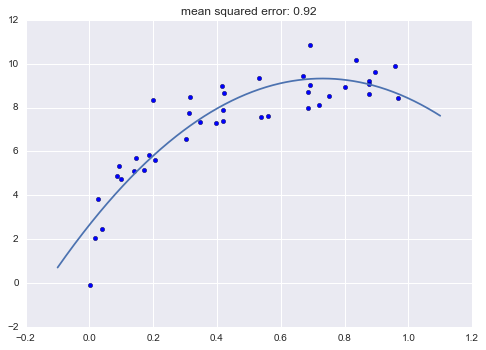

In [50]:
# grau de liberdade igual a 2 (parábola)
model = PolynomialRegression(2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)));

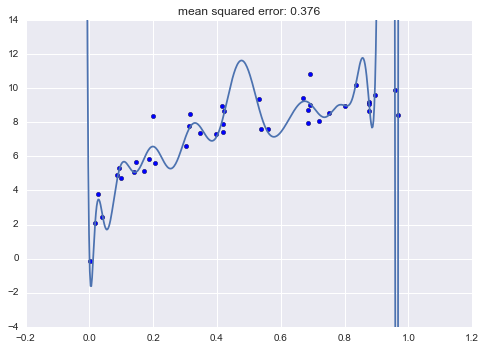

In [51]:
model = PolynomialRegression(30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.title("mean squared error: {0:.3g}".format(mean_squared_error(model.predict(X), y)))
plt.ylim(-4, 14);

Neste caso, exageramos. Temos um modelo com **alta variância**, ou um modelo **super especialista (overfitting)**

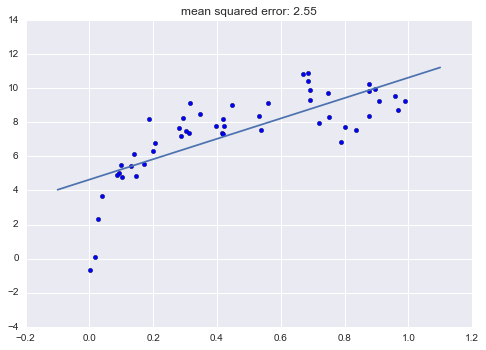

In [52]:
from IPython.html.widgets import interact

def plot_fit(degree=1, Npts=50):
    X, y = make_data(Npts, error=1)
    X_test = np.linspace(-0.1, 1.1, 500)[:, None]
    
    model = PolynomialRegression(degree=degree)
    model.fit(X, y)
    y_test = model.predict(X_test)

    plt.scatter(X.ravel(), y)
    plt.plot(X_test.ravel(), y_test)
    plt.ylim(-4, 14)
    plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))
    
interact(plot_fit, degree=[1, 30], Npts=[2, 100]);

### Curvas de validação

![tradeoff](../images/tradeoff.png)

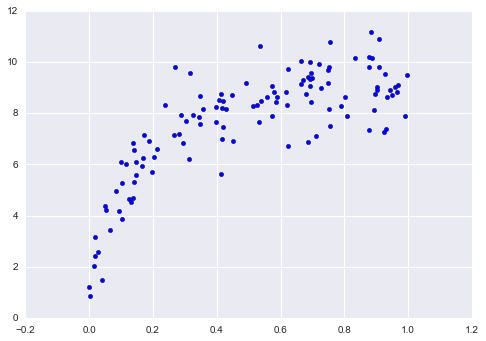

In [53]:
X, y = make_data(120, error=1.0)
plt.scatter(X, y);

In [54]:
from sklearn.learning_curve import validation_curve

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

degree = np.arange(0, 18)
val_train, val_test = validation_curve(PolynomialRegression(), X, y,
                                       'polynomialfeatures__degree', degree, cv=7,
                                       scoring=rms_error)

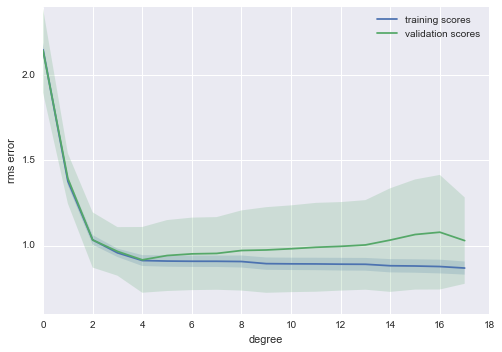

In [55]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(degree, val_train, label='training scores')
plot_with_err(degree, val_test, label='validation scores')
plt.xlabel('degree'); plt.ylabel('rms error')
plt.legend();

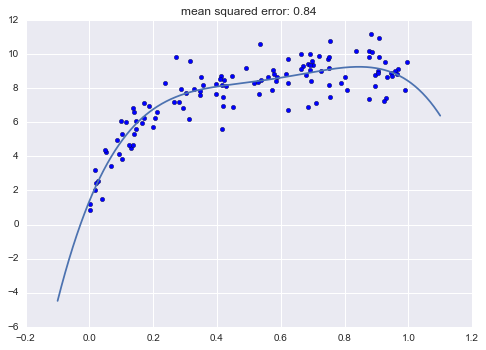

In [61]:
model = PolynomialRegression(4).fit(X, y)
plt.scatter(X, y)
plt.plot(X_test, model.predict(X_test));
plt.title("mean squared error: {0:.2f}".format(mean_squared_error(model.predict(X), y)))

### Ponto de Operação e Tamanho dos Conjuntos

In [64]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

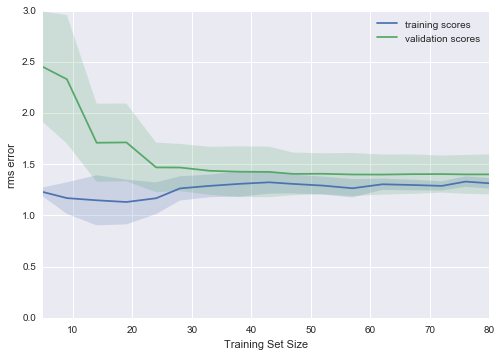

In [63]:
plot_learning_curve(1)


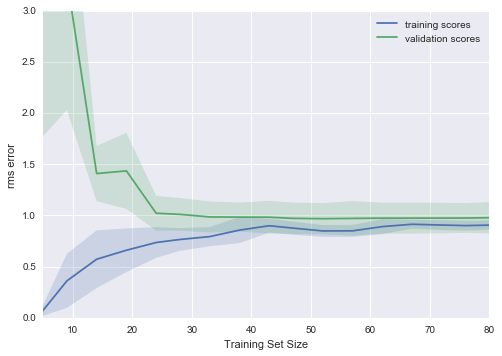

In [65]:
plot_learning_curve(3)


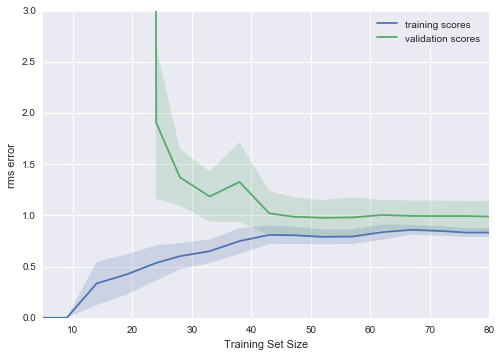

In [66]:
plot_learning_curve(10)


Observe que:
1. Você consegue abaixar o erro RMS apenas aumentando um pouco a complexidade
2. Você pode obter convergência aumentando o tamanho da amostra

Estas curvas te dão dicas de como iterar sobre o modelo.

* Se as curvas estão muito próximas, provavelmente você precisa aumentar a complexidade do modelo
* Se as curvas estão muito distantes, provavelmente você consegue melhorar o modelo aumentando o tamanho da amostra

## Resumão


Você aprendeu bastante coisa sobre validação de modelos.

O *score* de treino indica quão bem o modelo foi treinado. Mas não indica quão **eficiente** é o modelo.

O *score* de validação indica quão bem o modelo está generalizando. O método mais eficiente é o **Validação Cruzada**.

As **curvas de validação** indicam o **ponto ótimo de operação**:
* quando as curvas estão muito próximas, temos **under-fitting**. Aumentar o tamanho da amostra não vai ajudar!
* quando as curvas estão muito separadas, temos **over-fitting**. Aumentar o tamanho da amostra pode ajudar, neste caso!